In [1]:
import exmp
import os.path
import qiime2
import numpy as np

import pandas as pd
import scipy as sp

from qiime2.plugins.diversity.methods import pcoa as pcoa_method, filter_distance_matrix
from qiime2.plugins.longitudinal.visualizers import anova

In [2]:
uu_dm = qiime2.Artifact.load(os.path.join(exmp.cm_grouped_by_period_path, "unweighted_unifrac_distance_matrix.qza"))
wu_dm = qiime2.Artifact.load(os.path.join(exmp.cm_grouped_by_period_path, "weighted_unifrac_distance_matrix.qza"))
faith_pd = qiime2.Artifact.load(os.path.join(exmp.cm_grouped_by_period_path, "faith_pd_vector.qza"))
shannon = qiime2.Artifact.load(os.path.join(exmp.cm_grouped_by_period_path, "shannon_vector.qza"))
evenness = qiime2.Artifact.load(os.path.join(exmp.cm_grouped_by_period_path, "evenness_vector.qza"))
sample_metadata = exmp.load_sample_metadata_grouped_by_period()

/Users/gregcaporaso/Dropbox/shared-analysis-results/2019.09-exmp/exmp-paper1/code/exmp.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped_sample_metadata['period'])]


In [3]:
dep_variable = 'three_rep_max_squat_change'
project = 'exmp2'
where = "[project]='%s' and [period]=1" % project

ids_to_keep = sample_metadata.get_ids(where=where)
sample_metadata = sample_metadata.filter_ids(ids_to_keep=ids_to_keep)

# make column names compatible for R-like forumulas used in anova
_df = sample_metadata.to_dataframe()
_df.index.name = 'sample-id'
_df = _df.rename(columns={'VO2max-change': 'VO2max_change',
                          'RER-change': 'RER_change',
                          'row-change': 'row_change',
                          'bench-press-change': 'bench_press_change',
                          '3RM-squat-change': 'three_rep_max_squat_change'})

# drop columns that don't have necessary data
if project == 'exmp1':
    _df = _df[['VO2max_change', 'RER_change']].dropna().astype(np.float)
else:
    _df = _df[['row_change', 'bench_press_change', 'three_rep_max_squat_change']].dropna().astype(np.float)
sample_metadata = qiime2.Metadata(_df)

uu_dm = filter_distance_matrix(uu_dm, metadata=sample_metadata).filtered_distance_matrix
wu_dm = filter_distance_matrix(wu_dm, metadata=sample_metadata).filtered_distance_matrix

In [4]:

wu_pcoa = pcoa_method(wu_dm).pcoa
wu_pcoa = wu_pcoa.view(qiime2.Metadata).to_dataframe()[['Axis 1', 'Axis 2', 'Axis 3']]
wu_pcoa = wu_pcoa.rename(columns={'Axis 1': 'Weighted_UniFrac_PC1', 
                                  'Axis 2': 'Weighted_UniFrac_PC2', 
                                  'Axis 3': 'Weighted_UniFrac_PC3'})
sample_metadata = sample_metadata.merge(qiime2.Metadata(wu_pcoa))

uu_pcoa = pcoa_method(uu_dm).pcoa
uu_pcoa = uu_pcoa.view(qiime2.Metadata).to_dataframe()[['Axis 1', 'Axis 2', 'Axis 3']]
uu_pcoa = uu_pcoa.rename(columns={'Axis 1': 'Unweighted_UniFrac_PC1', 
                                  'Axis 2': 'Unweighted_UniFrac_PC2', 
                                  'Axis 3': 'Unweighted_UniFrac_PC3'})
sample_metadata = sample_metadata.merge(qiime2.Metadata(uu_pcoa))

sample_metadata = sample_metadata.merge(faith_pd.view(qiime2.Metadata).filter_ids(ids_to_keep=ids_to_keep))
sample_metadata = sample_metadata.merge(shannon.view(qiime2.Metadata).filter_ids(ids_to_keep=ids_to_keep))
sample_metadata = sample_metadata.merge(evenness.view(qiime2.Metadata).filter_ids(ids_to_keep=ids_to_keep))


df = sample_metadata.to_dataframe()

/Users/gregcaporaso/miniconda3/envs/qiime2-2019.10/lib/python3.6/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.028544618886374468 and the largest is 1.881419611086452.
  RuntimeWarning


In [5]:
df.corr(method='spearman')


,row_change,bench_press_change,three_rep_max_squat_change,Weighted_UniFrac_PC1,Weighted_UniFrac_PC2,Weighted_UniFrac_PC3,Unweighted_UniFrac_PC1,Unweighted_UniFrac_PC2,Unweighted_UniFrac_PC3,faith_pd,shannon,pielou_e
row_change,1.000000,0.376307,0.596151,0.062743,0.023429,-0.151298,-0.216820,-0.051227,0.343100,0.070288,0.039711,0.002780
bench_press_change,0.376307,1.000000,0.342651,0.037473,-0.002367,0.067845,-0.189335,-0.062717,-0.065873,0.014200,-0.123856,-0.125829
three_rep_max_squat_change,0.596151,0.342651,1.000000,0.086185,0.102030,-0.350535,0.028986,-0.001932,0.259713,-0.128311,0.023575,0.148021
Weighted_UniFrac_PC1,0.062743,0.037473,0.086185,1.000000,0.297692,0.008462,0.289231,0.068462,0.563846,-0.264615,0.091538,0.217692
Weighted_UniFrac_PC2,0.023429,-0.002367,0.102030,0.297692,1.000000,-0.059231,0.413077,-0.046154,0.196154,-0.436154,-0.690769,-0.676923
Weighted_UniFrac_PC3,-0.151298,0.067845,-0.350535,0.008462,-0.059231,1.000000,-0.460769,0.344615,-0.020000,0.454615,0.246154,0.050000
Unweighted_UniFrac_PC1,-0.216820,-0.189335,0.028986,0.289231,0.413077,-0.460769,1.000000,-0.024615,0.040769,-0.904615,-0.455385,-0.135385
Unweighted_UniFrac_PC2,-0.051227,-0.062717,-0.001932,0.068462,-0.046154,0.344615,-0.024615,1.000000,0.094615,0.246154,0.243846,0.228462
Unweighted_UniFrac_PC3,0.343100,-0.065873,0.259713,0.563846,0.196154,-0.020000,0.040769,0.094615,1.000000,-0.070769,0.239231,0.168462
faith_pd,0.070288,0.014200,-0.128311,-0.264615,-0.436154,0.454615,-0.904615,0.246154,-0.070769,1.000000,0.583846,0.254615


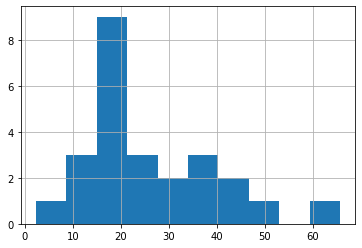

In [6]:
%matplotlib inline
df[dep_variable].hist()

In [11]:
print("Sample size: %d subjects." % df.shape[0])


Sample size: 25 subjects.


In [7]:
anova(metadata=qiime2.Metadata(df),
      formula= dep_variable + " ~ faith_pd + shannon + pielou_e + \
               Weighted_UniFrac_PC1 + Weighted_UniFrac_PC2 + Weighted_UniFrac_PC3 + \
               Unweighted_UniFrac_PC1 + Unweighted_UniFrac_PC2 + Unweighted_UniFrac_PC3").visualization

<visualization: Visualization uuid: a9869fc8-a455-4893-9337-a9330edcf5bb>